In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

import target_predicting_RF_function_and_feature_ranking_TNGSIM_0D as functions
import RF_target_predicting_and_learning_curves_functions_TNGSIM_0D as tp_lc_functions

In [2]:
# Using the 0D TNG100 SIM data at z=0 (version 5 of the dataset in this notebook, 
# for further explanation see Notebook v3 updated and v14)

df_0D = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v6_TNG-SIM_0D_Dataset_wMvir.csv')
df_raw = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v4_TNG-SIM_Raw_Dataset.csv')
print("df_0D.shape", df_0D.shape)
print("df_raw.shape", df_raw.shape)

df_0D.shape (21598, 17)
df_raw.shape (21598, 19)


### <font color='purple'> <a id =10> </a> <br> Take Log10 of all features and target, both 0D & raw

In [3]:
def log_df(df_init):
    
    df = df_init.copy()
    for feature in df.columns.to_list():
        if 'log' not in feature:
            df.loc[:, feature + '_log']=df.loc[:,feature].apply(lambda x: np.log10(x + 1.e-8))
            df.drop(columns = [feature], inplace = True)
#             print(df.loc[:, feature])
        else:continue
        
    return df

In [4]:
df_raw_log = log_df(df_raw)

In [5]:
df_raw_log.head(2)

,SubhaloBHMass_log,SubhaloBHMdot_log,SubhaloGasMetallicity_log,SubhaloSFRinRad_log,SubhaloStarMetallicity_log,SubhaloVelDisp_log,SubhaloVmax_log,SubhaloVmaxRad_log,SubhaloRgas_log,SubhaloRstar_log,SubhaloMgas_log,SubhaloMstar_log,GroupNsubs_log,Group_M_TopHat200_log,Group_R_TopHat200_log,SubhaloMHI_log,SubhaloMH2_log,Group_V_TopHat200_log,GroupSpin_dmo_log
0,9.998109,-3.400095,-2.112483,-0.708133,-1.543295,2.780947,2.999733,2.668073,2.949910,1.828096,13.092064,12.497443,4.235150,14.646987,3.292134,10.061858,10.043734,2.994161,-1.769689
1,9.898275,-4.012083,-2.359742,0.219496,-1.679031,2.774496,2.981978,3.134860,2.988572,2.098578,13.610459,12.316876,4.150971,14.687475,3.305635,9.899765,9.955786,3.007654,-1.893303


In [6]:
df_raw_log.shape

(21598, 19)

In [7]:
df_raw.shape

(21598, 19)

In [8]:
df_0D_log = log_df(df_0D)

In [9]:
df_0D_log.shape

(21598, 17)

In [10]:
df_0D.shape

(21598, 17)

### <font color='purple'> <a id =10> </a> <br> Define disks dataset as explained in Notebook v21

In [12]:
df_mstarcut_raw_log = df_raw_log[(df_raw_log.SubhaloMstar_log>=8.3) & (df_raw_log.SubhaloMstar_log<=11)]
print('df_mstarcut_raw_log.shape;', df_mstarcut_raw_log.shape)
df_sfrcut_raw_log = df_mstarcut_raw_log[(df_mstarcut_raw_log.SubhaloSFRinRad_log>=-1.2) & 
                                          (df_mstarcut_raw_log.SubhaloSFRinRad_log<=1.0)]
print('df_sfrcut_raw_log.shape:', df_sfrcut_raw_log.shape)

df_mstarcut_raw_log.shape; (21308, 19)
df_sfrcut_raw_log.shape: (13879, 19)


In [13]:
# Using the slope above, point A[8.3, -1.2] and point B[11.0, 1.0], define the slope function below
# and then filter to only use the points in the upper part of the slope
slope = 0.82
intercept = -8.02

def calculate_yhat(x):
    
    yhat = slope * x + intercept 
    
    return yhat

In [14]:
y_hat = calculate_yhat(df_sfrcut_raw_log.SubhaloMstar_log)

# Define disk galaxies as the points above the SFR-Mstar slope 
df_disks_log = df_sfrcut_raw_log[df_sfrcut_raw_log.SubhaloSFRinRad_log >= y_hat]
print('df_disks_log.shape', df_disks_log.shape)

df_disks_log.shape (3215, 19)


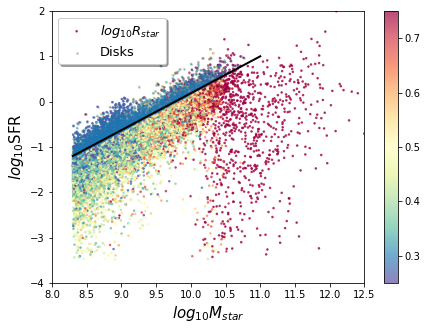

In [60]:
# Plot of log SFR vs log Mstar to see the trend and define disk galaxies

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR1 = ax.scatter(df_raw_log.SubhaloMstar_log, df_raw_log.SubhaloSFRinRad_log,
            c = df_raw_log.SubhaloRstar_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}R_{star}$', vmin=0.25, vmax=0.75)
fig_SR = ax.scatter(df_sfrcut_raw_log.SubhaloMstar_log[df_sfrcut_raw_log.SubhaloSFRinRad_log >= y_hat], df_sfrcut_raw_log.SubhaloSFRinRad_log[df_sfrcut_raw_log.SubhaloSFRinRad_log >= y_hat],
            #c = df_sfrcut_raw_log2.SubhaloRstar_log, 
            s=10, marker='.', alpha=0.3,label= r'Disks') #, vmin=0.25, vmax=0.75)

# ax.text(-0.15, 1.35, r'$R^{2}$ score=blabla', size=12)
ax.axis([8.0,12.5, -4, 2.0])
ax.plot([8.3, 11.0], [-1.2, 1.0], color = 'black', linewidth = 2)
# ax.set_title(r'$log_{10}$SFR vs $log_{10}$Mstar all dataset vs SFR cut')
ax.set_xlabel(r'$log_{10}M_{star}$', fontsize=15)
ax.legend(loc = 'upper left', shadow=True, fontsize=13)
ax.set_ylabel(r'$log_{10}$SFR', fontsize=15)
fig_complete.colorbar(fig_SR1, ax=ax)
# plt.savefig('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_SFR_vs_Mstar_colorRstar_Disks_notitle.pdf', dpi=500)
plt.show()

### <font color='purple'> <a id =10> </a> <br> Inverse-log disks dataset as to define them we need their log version, but to halo-scale them, we need their original version

In [16]:
def inverse_log_df(df_init):
    
    df = df_init.copy()
    for feature in df.columns.to_list():
        if 'log' in feature:
            
            df.loc[:, feature[:-4]]=df.loc[:,feature].apply(lambda x: 10**(x - 1.e-8))
            df.drop(columns = [feature], inplace = True)

        else:continue
        
    return df

In [17]:
df_disks_original = inverse_log_df(df_disks_log)

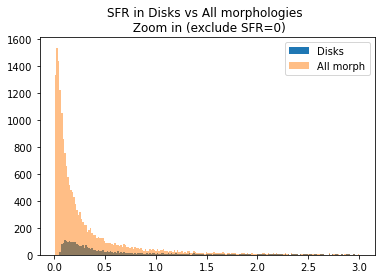

In [18]:
plt.hist(df_disks_original.SubhaloSFRinRad, bins=200,
        label='Disks', range=(0.01, 3))
plt.hist(df_raw.SubhaloSFRinRad, bins=200, alpha=0.5, label='All morph',
        range=(0.01, 3))
plt.legend(loc='upper right')
plt.title('SFR in Disks vs All morphologies \n Zoom in (exclude SFR=0)')
plt.show()

### <font color='purple'> <a id =10> </a> <br> Halo-scale the inverse-log (original) disks dataset

In [19]:
def normalization_func(df):
    '''
    Normalizes the dataset by dividing all masses by halo mass, and galaxy size by halo size, velocities by halo velocity

    '''
#     could also use the method below
#     df_log_mass_filtered.loc[:,'GalpropNormMstar']=df_log_mass_filtered.loc[:,'GalpropMstar'].div(df_log_mass_filtered.HalopropMvir, axis=0)
    
    df =df.copy()
    
    # define halomass, halo radius and halo velocity
    halomass=df.loc[:,'Group_M_TopHat200'] # Q: ShoulD I use this, or the _dmo version of it? Why? Ans: Looking at the histogram, they seem to be the same, so use this mass
    halorad= df.loc[:,'Group_R_TopHat200']
    halovel= df.loc[:,'Group_V_TopHat200']
    
    # dimensionless form of halfmass radius, Rgas and the radius at which Vmax occurs
    df.loc[:,'SubhaloRstar_hs']=df.loc[:,'SubhaloRstar']/halorad # halfmass radius
    df.loc[:,'SubhaloRgas_hs']=df.loc[:,'SubhaloRgas']/halorad # galaxy size in gas? 
    df.loc[:,'SubhaloVmaxRad_hs']=df.loc[:,'SubhaloVmaxRad']/halorad # Vmax is the maximum circular velocity. VmaxRad is the radius at which Vmax occurs. 
    
    # dimensionless form of circular velocities
    df.loc[:,'SubhaloVmax_hs']=df.loc[:,'SubhaloVmax']/halovel 
    df.loc[:,'SubhaloVelDisp_hs']=df.loc[:,'SubhaloVelDisp']/halovel 
   
    
    # dimensionless form of masses
    df.loc[:,'SubhaloMgas_hs']=df.loc[:,'SubhaloMgas']/halomass 
    df.loc[:,'SubhaloMstar_hs']=df.loc[:,'SubhaloMstar']/halomass
    df.loc[:,'SubhaloBHMass_hs']=df.loc[:,'SubhaloBHMass']/halomass
    df.loc[:,'SubhaloBHMdot_hs']=df.loc[:,'SubhaloBHMdot']/halomass
    df.loc[:,'SubhaloMHI_hs']=df.loc[:,'SubhaloMHI']/halomass
    df.loc[:,'SubhaloMH2_hs']=df.loc[:,'SubhaloMH2']/halomass
    
    # dimensionless form of halo size (not very imp)
#     df.loc[:,'Group_R_TopHat200_hs']=df.loc[:,'Group_R_TopHat200']/halorad # this is 1

    # dimensionless form of halo mass (not very imp)
#     df.loc[:,'Group_M_TopHat200_hs']=df.loc[:,'Group_M_TopHat200']/halomass # this is 1

    
    # dimensionless form of halo velocity (not very imp)
#     df.loc[:,'Group_V_TopHat200_hs']=df.loc[:,'Group_V_TopHat200']/halovel # this is 1
   
    # Drop all the columns that are halo-scaled, and the three features used for halo-scaling
    df = df.drop(columns = ['Group_R_TopHat200', 'Group_V_TopHat200', # do not drop Mvir
                           'SubhaloRstar', 'SubhaloRgas', 'SubhaloVmaxRad',
                           'SubhaloVmax', 'SubhaloVelDisp',
                           'SubhaloMgas', 'SubhaloMstar', 'SubhaloBHMass', 'SubhaloBHMdot',
                           'SubhaloMHI', 'SubhaloMH2'])
    # 28 lines
    return df

In [20]:
df_disks_0D = normalization_func(df_disks_original)
print('df_disks_0D.shape',df_disks_0D.shape)
print('df_disks_original.shape',df_disks_original.shape)

df_disks_0D.shape (3215, 17)
df_disks_original.shape (3215, 19)


### <font color='purple'> <a id =10> </a> <br> Take the log of the 0D (halo-scaled) disks dataset

In [21]:
df_disks_0D_log = log_df(df_disks_0D)
print(df_disks_0D_log.shape)

(3215, 17)


In [61]:
print(df_disks_0D_log.shape)
print(df_disks_0D.shape)
print(df_disks_log.shape)
print(df_disks_original.shape)

(3215, 17)
(3215, 17)
(3215, 19)
(3215, 19)


### Save the Disks dataset

In [63]:
# df_disks_original.to_csv('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_TNG-SIM_Disks_Dataset_Raw.csv', index=False)
# df_disks_log.to_csv('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_TNG-SIM_Disks_Dataset_LogRaw.csv', index=False)
# df_disks_0D.to_csv('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_TNG-SIM_Disks_0D_wMvir_Dataset.csv', index=False)
# df_disks_0D_log.to_csv('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_TNG-SIM_Disks_Log0D_wMvir_Dataset.csv', index=False)


### <font color='purple'> <a id =10> </a> <br> Complete 0D Dataset: SVR

In [22]:
X_all = df_disks_0D_log.drop(columns=['SubhaloRstar_hs_log'])
 

y_all = df_disks_0D_log.loc[:,'SubhaloRstar_hs_log']

In [23]:
# this code takes ~ ...min to run it on the complete TNG-SIM dataset with ~22,000 galaxies 

start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale', 0.01, 1.0, 10, 100], 
              'svr__C':[0.1, 1.0, 10.0, 100.0, 1000], \
              'svr__epsilon':[0.05,0.1,0.2],
              }


model_all = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

model_all.fit(X_all, y_all)

print('Best params, best score:', "{:.4f}".format(model_all.best_score_), \
      model_all.best_params_)

elapsed_time = time.time() - start_time
elapsed_time_min = elapsed_time/60
print(f"Elapsed time to compute the SVR results on TNG-SIM 0D Disks Dataset: {elapsed_time:.3f} seconds, {elapsed_time_min:.3f} minutes")

Fitting 3 folds for each of 75 candidates, totalling 225 fits
Best params, best score: 0.8566 {'svr__C': 10.0, 'svr__epsilon': 0.05, 'svr__gamma': 0.01, 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on TNG-SIM 0D Disks Dataset: 18.635 seconds, 0.311 minutes


Fitting 3 folds for each of 75 candidates, totalling 225 fits

Best params, best score: 0.8566 {'svr__C': 10.0, 'svr__epsilon': 0.05, 'svr__gamma': 0.01, 'svr__kernel': 'rbf'}

Elapsed time to compute the SVR results on TNG-SIM 0D Disks Dataset: 18.635 seconds, 0.311 minutes

#### Note: Including Mvir (0D+Mvir) increases the SVR R2 from 0.79 to 0.86!

In [24]:
start_time = time.time()

best_SVR_all=model_all.best_estimator_

best_SVR_trainscore_all=model_all.cv_results_['mean_train_score'][model_all.best_index_]

scores_SVR_all = cross_val_score(best_SVR_all, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute this patch of code: {elapsed_time:.3f} seconds")

# It took 53 seconds ~ 1min to run this patch of code

Elapsed time to compute this patch of code: 1.104 seconds


In [25]:
start_time = time.time()

y_pred_SVR_all = cross_val_predict(best_SVR_all, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10))

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR y_pred with cv=5 and optimal model from above, on 0D+Mvir Disks: {elapsed_time:.3f} seconds")

# It took 54 seconds ~ 1min to run this patch of code

Elapsed time to compute the SVR y_pred with cv=5 and optimal model from above, on 0D+Mvir Disks: 1.095 seconds


In [30]:
y_pred_SVR_df_all = pd.DataFrame({'y_pred_SVR SIM 0D Disks': y_pred_SVR_all})

# y_pred_SVR_df_all.to_csv('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_Disks_TNG-SIM_0DwMvir_y_pred_SVR_predicted_sizes.csv', index=False)

y_pred_SVR_all = pd.read_csv('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_Disks_TNG-SIM_0DwMvir_y_pred_SVR_predicted_sizes.csv')

In [31]:
best_SVR_trainscore_all

0.8924749107378694

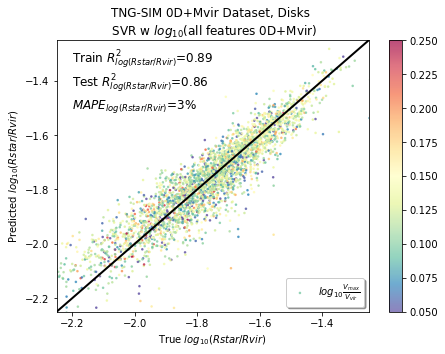

In [38]:
# Plot of Predicted log10 Rstar/Rvir vs True log 10 Rstar/Rvir

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_disks_0D_log.SubhaloRstar_hs_log, y_pred_SVR_all,
            c = df_disks_0D_log.SubhaloVmax_hs_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}\frac{V_{max}}{V_{vir}}$', vmin=0.05, vmax=0.25)
ax.text(-2.2, -1.5, r'Train $R^{2}_{log(Rstar/Rvir)}$=0.89' + '\n' + r'Test $R^{2}_{log(Rstar/Rvir)}$=0.86' + '\n' + r'$MAPE_{log(Rstar/Rvir)}$=3$\%$ ', size=12)
ax.axis([-2.25,-1.25, -2.25,-1.25])
ax.plot([-3.0, -1.0], [-3.0, -1.0], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM 0D+Mvir Dataset, Disks \n ' + r'SVR w $log_{10}$(all features 0D+Mvir) ')
ax.set_xlabel(r'True $log_{10}(Rstar/Rvir)$')
ax.set_ylabel(r'Predicted $log_{10}(Rstar/Rvir)$')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_Disks_TNG-SIM_0DwMvir_SVR_size_pred_colorlogVmaxVvir_1.jpeg', dpi=500)
plt.show()

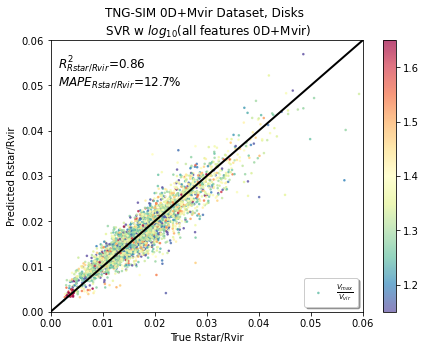

In [39]:
# Plot of Predicted Rstar/Rvir vs Rstar/Rvir 

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(10**(df_disks_0D_log.SubhaloRstar_hs_log), 10**(y_pred_SVR_all),
            c = df_disks_0D.SubhaloVmax_hs, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$\frac{V_{max}}{V_{vir}}$', vmin=1.15, vmax=1.65)
ax.text(0.0015, 0.05, r'$R^{2}_{Rstar/Rvir}$=0.86' + '\n' + r'$MAPE_{Rstar/Rvir}$=12.7$\%$ ', size=12)
ax.axis([0.0,0.06, 0.0,0.06])
ax.plot([-3.0, 1.0], [-3.0, 1.0], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM 0D+Mvir Dataset, Disks \n ' + r'SVR w $log_{10}$(all features 0D+Mvir) ')
ax.set_xlabel(r'True Rstar/Rvir')
ax.set_ylabel(r'Predicted Rstar/Rvir')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_Disks_TNG-SIM_0DwMvir_SVR_size_pred_colorlogVmaxVvir_2.jpeg', dpi=500)
plt.show()

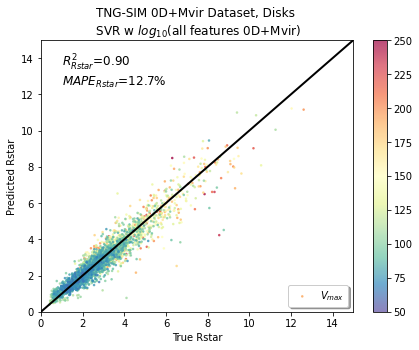

In [44]:
# Plot of Predicted Raw Rstar vs Raw Rstar 

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_disks_original.SubhaloRstar,  (10**(y_pred_SVR_all_copy.loc[:,'y_pred_SVR SIM 0D Disks']- 1.e-8))*df_disks_original_copy.Group_R_TopHat200,
            c = df_disks_original.SubhaloVmax, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$V_{max}$', vmin=50, vmax=250)
ax.text(1.0, 12.5, r'$R^{2}_{Rstar}$=0.90' + '\n' + r'$MAPE_{Rstar}$=12.7$\%$ ', size=12)
ax.axis([0.0,15, 0.0,15])
ax.plot([-3.0, 30], [-3.0, 30], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM 0D+Mvir Dataset, Disks \n ' + r'SVR w $log_{10}$(all features 0D+Mvir) ')
ax.set_xlabel(r'True Rstar')
ax.set_ylabel(r'Predicted Rstar')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_Disks_TNG-SIM_0DwMvir_SVR_size_pred_colorlogVmaxVvir_3zoom.jpeg', dpi=500)
plt.show()

### Other metrics

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

##### <font color='darkgreen'> <a id =10> </a> <br>log(Rstar/Rvir) metrics

In [33]:
print('r2 score log(Rstar/Rvir)', r2_score(df_disks_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D Disks']))
print('MSE log(Rstar/Rvir)', mean_squared_error(df_disks_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D Disks']))
print('sqrtMSE log(Rstar/Rvir)',np.sqrt(mean_squared_error(df_disks_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D Disks'])))
print('MAE log(Rstar/Rvir)', mean_absolute_error(df_disks_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D Disks']))
print('MAPE log(Rstar/Rvir)',# MAPE in log scale
mean_absolute_percentage_error(df_disks_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D Disks']))

r2 score log(Rstar/Rvir) 0.8580828225887025
MSE log(Rstar/Rvir) 0.005627767593999664
sqrtMSE log(Rstar/Rvir) 0.07501844835771841
MAE log(Rstar/Rvir) 0.05491512373690386
MAPE log(Rstar/Rvir) 0.030376991543992787


##### <font color='darkgreen'> <a id =10> </a> <br>Rstar/Rvir metrics

In [35]:
print('r2 score Rstar/Rvir', r2_score(df_disks_0D.loc[:, 'SubhaloRstar_hs'], 10**(y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D Disks'] - 1.e-8)))
print('MSE Rstar/Rvir', mean_squared_error(df_disks_0D.loc[:, 'SubhaloRstar_hs'], 10**(y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D Disks'] - 1.e-8)))
print('sqrtMSE Rstar/Rvir', np.sqrt(mean_squared_error(df_disks_0D.loc[:, 'SubhaloRstar_hs'], 10**(y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D Disks'] - 1.e-8))))
print('MAPE Rstar/Rvir', # MAPE in original variables
mean_absolute_percentage_error(10**(df_disks_0D_log.loc[:, 'SubhaloRstar_hs_log']), 10**(y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D Disks'] - 1.e-8)))

r2 score Rstar/Rvir 0.8630981848061147
MSE Rstar/Rvir 7.746055124058762e-06
sqrtMSE Rstar/Rvir 0.0027831735705950433
MAPE Rstar/Rvir 0.12780845739881863


### <font color='darkred'> <a id =10> </a> <br> Problem of NaNs when multiplying predicted Rstar with Rvir (y_pred_SVR_all with df_disks_original.Group_R_TopHat200):

Solution (from StackOverflow): The problem is in indexing - your data frames have got different indices. To make your code work, unify indices in both data frames by pandas.DataFrame.reset_index() method. You can use the following code: df1.reset_index(inplace=True). The code will change index in df1 on integers from 0 to 17, which will be the same index as df2 has got.

This is the solution of my problem as the indexing of the two dataframes (y_pred_SVR_all and df_disks_original) is different from each other.

In [40]:
 (10**(y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D Disks']- 1.e-8))*df_disks_original.Group_R_TopHat200

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
21033   NaN
21055   NaN
21080   NaN
21107   NaN
21207   NaN
Length: 6024, dtype: float64

In [41]:
y_pred_SVR_all_copy = y_pred_SVR_all.copy()

df_disks_original_copy = df_disks_original.copy()

df_disks_original_copy.reset_index(inplace=True)

y_pred_SVR_all_copy.reset_index(inplace=True)

In [42]:
 (10**(y_pred_SVR_all_copy.loc[:,'y_pred_SVR SIM 0D Disks']- 1.e-8))*df_disks_original_copy.Group_R_TopHat200

0        3.536837
1        6.495860
2       11.157807
3        7.893609
4        4.230360
          ...    
3210     1.696352
3211     1.664358
3212     1.226984
3213     1.653074
3214     1.323477
Length: 3215, dtype: float64

##### <font color='darkgreen'> <a id =10> </a> <br> Rstar metrics

In [43]:
print('r2 score Rstar', r2_score(df_disks_original.loc[:, 'SubhaloRstar'],  (10**(y_pred_SVR_all_copy.loc[:,'y_pred_SVR SIM 0D Disks']- 1.e-8))*df_disks_original_copy.Group_R_TopHat200))
print('MSE Rstar',mean_squared_error(df_disks_original.loc[:, 'SubhaloRstar'],  (10**(y_pred_SVR_all_copy.loc[:,'y_pred_SVR SIM 0D Disks']- 1.e-8))*df_disks_original_copy.Group_R_TopHat200))
print('sqrtMSE Rstar',np.sqrt(mean_squared_error(df_disks_original.loc[:, 'SubhaloRstar'],  (10**(y_pred_SVR_all_copy.loc[:,'y_pred_SVR SIM 0D Disks']- 1.e-8))*df_disks_original_copy.Group_R_TopHat200)))
print('MAPE Rstar', mean_absolute_percentage_error(df_disks_original.loc[:, 'SubhaloRstar'],  (10**(y_pred_SVR_all_copy.loc[:,'y_pred_SVR SIM 0D Disks']- 1.e-8))*df_disks_original_copy.Group_R_TopHat200))

r2 score Rstar 0.9023029368967487
MSE Rstar 0.22567190180155333
sqrtMSE Rstar 0.47504936775197726
MAPE Rstar 0.12780867671717708


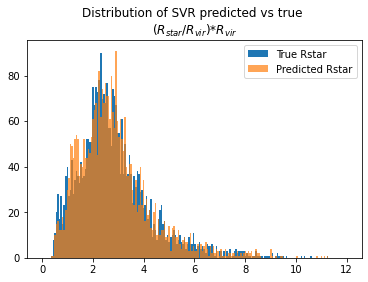

In [46]:
plt.hist(10**(df_disks_0D_log.SubhaloRstar_hs_log)*df_disks_original.Group_R_TopHat200, label='True Rstar',
         bins=200, range=(0.0, 12)) 
plt.hist((10**(y_pred_SVR_all_copy.loc[:,'y_pred_SVR SIM 0D Disks']- 1.e-8))*df_disks_original_copy.Group_R_TopHat200, label='Predicted Rstar', alpha=0.7, 
         bins=200, range=(0.0, 12))
plt.legend(loc='upper right')
plt.title('Distribution of SVR predicted vs true \n'+r'($R_{star}$/$R_{vir}$)*$R_{vir}$')
# plt.savefig('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_SVRPredicted_vs_True_Rstar_distribution.jpeg', dpi=500)
plt.show()

In [47]:
y_pred_SVR_all

,y_pred_SVR SIM 0D Disks
0,-1.936847
1,-1.804019
2,-1.559930
3,-1.670536
4,-1.974164
...,...
3210,-1.720530
3211,-1.733050
3212,-1.874125
3213,-1.733555


### <font color='purple'> <a id =3> </a> <br> SVR Learning Curve

In [48]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'r2', scale = False):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    
    fig, ax = plt.subplots(figsize=(7, 5))
#     plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("# of training examples",fontsize = 14)
 
    ax.set_ylabel(r"$R^{2}$ score",fontsize = 14)
    
    if (scale == True):
        scaler = sklearn.preprocessing.StandardScaler()
        X = scaler.fit_transform(X)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score from CV")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from CV")

    ax.legend(loc="best",fontsize = 12)
    return fig

Elapsed time to run SVR Learning Curves on the 0D+Mvir Disks dataset: 1.556 seconds


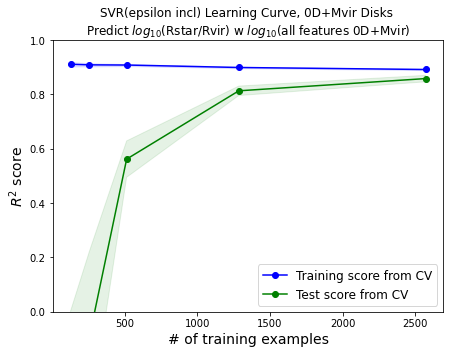

In [49]:
# this code takes ~2.5min to run on the whole dataset with ~22,000 galaxies
start_time = time.time()

lc_all = plot_learning_curve(best_SVR_all, 'SVR(epsilon incl) Learning Curve, 0D+Mvir Disks \n'+r'Predict $log_{10}$(Rstar/Rvir) w $log_{10}$(all features 0D+Mvir)', X_all, y_all, ylim=(0.0, 1.0), train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
elapsed_time = time.time() - start_time

print(f"Elapsed time to run SVR Learning Curves on the 0D+Mvir Disks dataset: {elapsed_time:.3f} seconds")

In [50]:
# lc_all.savefig('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_Disks_TNG-SIM_0DwMvir_SVR_Learning_Curve.jpeg', dpi=500)

### <font color='purple'> <a id =3> </a> <br> SVR Add-on Feature Ranking
   

In [51]:
def run_svr_search_pipeline(X, y):
    
    
    piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

    piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

    parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale', 0.01, 1.0, 10, 100], 
              'svr__C':[0.1, 1.0, 10.0, 100.0, 1000], \
              'svr__epsilon':[0.05,0.1,0.2], 
                 }


    model_all = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True, random_state=2024), \
                     verbose = 0, n_jobs = -1, return_train_score=True)

    model_all.fit(X, y)
    
    scores_lim = pd.DataFrame(model_all.cv_results_)

    scores_lim = scores_lim[['params','mean_test_score','std_test_score','mean_train_score', 'mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)
    
    return scores_lim

def calculate_r_score( X , y ,column_names):
    x_new = X[list(column_names)]
    # print(column_names)
    r_square = run_svr_search_pipeline(x_new, y)['mean_test_score']
    
    return r_square.max()


def print_results(max_col_names, max_col_rscores):
    k= 1
    for i, j in zip(max_col_names, max_col_rscores):
        print("\t", k, i,j)
        k +=1
        
def calc_ith_iteration( X, y, max_col_names, max_col_rscores, orj_column_names, i):
    r_score_dict = {}
    for column_names in tqdm(orj_column_names): # orj_column_names = original column names
        # count += 1
        # print(count, max_col_names , column_names)
        feature_list = max_col_names + [column_names]
        r_score = calculate_r_score(X , y ,feature_list)
        r_score_dict[column_names] = r_score
    
    max_col_names.append(max(r_score_dict, key=r_score_dict.get))
    max_col_rscores.append(max(r_score_dict.values()))
    # print("asdfasd", max_col_names[len(max_col_names) - 1])
    
    orj_column_names.remove(max_col_names[len(max_col_names) - 1])
    
    return max_col_names, max_col_rscores, orj_column_names, r_score_dict

  6%|██▋                                        | 1/16 [03:58<59:43, 238.93s/it]

	 1 SubhaloVmaxRad_hs_log 0.30707409065876284



 12%|█████▏                                   | 2/16 [22:42<2:57:07, 759.11s/it]

	 1 SubhaloVmaxRad_hs_log 0.30707409065876284
	 2 SubhaloMH2_hs_log 0.4695474734640704



 19%|███████▋                                 | 3/16 [40:43<3:16:20, 906.23s/it]

	 1 SubhaloVmaxRad_hs_log 0.30707409065876284
	 2 SubhaloMH2_hs_log 0.4695474734640704
	 3 SubhaloStarMetallicity_log 0.6354342484812207



 25%|██████████▎                              | 4/16 [59:15<3:17:30, 987.54s/it]

	 1 SubhaloVmaxRad_hs_log 0.30707409065876284
	 2 SubhaloMH2_hs_log 0.4695474734640704
	 3 SubhaloStarMetallicity_log 0.6354342484812207
	 4 Group_M_TopHat200_log 0.7195926763093308



 31%|████████████▏                          | 5/16 [1:11:29<2:44:17, 896.13s/it]

	 1 SubhaloVmaxRad_hs_log 0.30707409065876284
	 2 SubhaloMH2_hs_log 0.4695474734640704
	 3 SubhaloStarMetallicity_log 0.6354342484812207
	 4 Group_M_TopHat200_log 0.7195926763093308
	 5 SubhaloMstar_hs_log 0.791193687428506



 38%|██████████████▋                        | 6/16 [1:20:32<2:09:18, 775.87s/it]

	 1 SubhaloVmaxRad_hs_log 0.30707409065876284
	 2 SubhaloMH2_hs_log 0.4695474734640704
	 3 SubhaloStarMetallicity_log 0.6354342484812207
	 4 Group_M_TopHat200_log 0.7195926763093308
	 5 SubhaloMstar_hs_log 0.791193687428506
	 6 SubhaloGasMetallicity_log 0.809743266160325



 44%|█████████████████                      | 7/16 [1:28:36<1:42:04, 680.51s/it]

	 1 SubhaloVmaxRad_hs_log 0.30707409065876284
	 2 SubhaloMH2_hs_log 0.4695474734640704
	 3 SubhaloStarMetallicity_log 0.6354342484812207
	 4 Group_M_TopHat200_log 0.7195926763093308
	 5 SubhaloMstar_hs_log 0.791193687428506
	 6 SubhaloGasMetallicity_log 0.809743266160325
	 7 SubhaloSFRinRad_log 0.8343839714362135



 50%|███████████████████▌                   | 8/16 [1:35:28<1:19:21, 595.15s/it]

	 1 SubhaloVmaxRad_hs_log 0.30707409065876284
	 2 SubhaloMH2_hs_log 0.4695474734640704
	 3 SubhaloStarMetallicity_log 0.6354342484812207
	 4 Group_M_TopHat200_log 0.7195926763093308
	 5 SubhaloMstar_hs_log 0.791193687428506
	 6 SubhaloGasMetallicity_log 0.809743266160325
	 7 SubhaloSFRinRad_log 0.8343839714362135
	 8 SubhaloMHI_hs_log 0.8510265992175025



 56%|███████████████████████                  | 9/16 [1:40:36<58:56, 505.21s/it]

	 1 SubhaloVmaxRad_hs_log 0.30707409065876284
	 2 SubhaloMH2_hs_log 0.4695474734640704
	 3 SubhaloStarMetallicity_log 0.6354342484812207
	 4 Group_M_TopHat200_log 0.7195926763093308
	 5 SubhaloMstar_hs_log 0.791193687428506
	 6 SubhaloGasMetallicity_log 0.809743266160325
	 7 SubhaloSFRinRad_log 0.8343839714362135
	 8 SubhaloMHI_hs_log 0.8510265992175025
	 9 SubhaloVmax_hs_log 0.8604208862331246



 56%|█████████████████████▉                 | 9/16 [1:44:28<1:21:15, 696.55s/it]

	 1 SubhaloVmaxRad_hs_log 0.30707409065876284
	 2 SubhaloMH2_hs_log 0.4695474734640704
	 3 SubhaloStarMetallicity_log 0.6354342484812207
	 4 Group_M_TopHat200_log 0.7195926763093308
	 5 SubhaloMstar_hs_log 0.791193687428506
	 6 SubhaloGasMetallicity_log 0.809743266160325
	 7 SubhaloSFRinRad_log 0.8343839714362135
	 8 SubhaloMHI_hs_log 0.8510265992175025
	 9 SubhaloVmax_hs_log 0.8604208862331246
	 10 SubhaloMgas_hs_log 0.8664532797229475


Text(0, 0.5, '$R^{2}$ score')

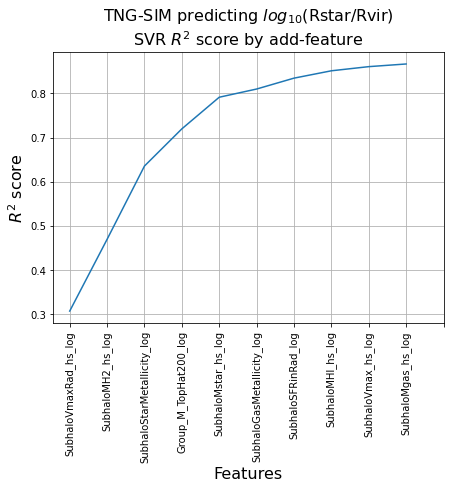

In [52]:
X = X_all
y = y_all

# Add-feature Ranking Method
# Note: This step calls 4 funcitons: run_random_search_pipeline(X,y), calculate_r_score(column_names),
# print_results(max_col_names, max_col_rscores), calc_ith_iteration(max_col_names, max_col_rscores, orj_column_names, i)

column_names = X.columns


max_col_names = [] # 
max_col_rscores = []
orj_column_names = list(column_names)


# first loop - over all features  
for i in tqdm(range(1, len(orj_column_names)+1)):
#     max_col_names, max_col_rscores, orj_column_names, r_score_dict = calc_ith_iteration(X, y, max_col_names, max_col_rscores, orj_column_names, i)
    
    
    # second loop, using i selected features + each of the remaining features individually
    r_score_dict = {} # to store r_squares from second loop
    
    for column_name in tqdm(orj_column_names,miniters = 6,colour = 'red', leave = None): 
        
        feature_list = max_col_names + [column_name]

        r_square = run_svr_search_pipeline(X[feature_list], y)
        r_score_dict[column_name] = r_square['mean_test_score'].max()
    
    max_col_names.append(max(r_score_dict, key=r_score_dict.get))
    max_col_rscores.append(max(r_score_dict.values()))

    
    orj_column_names.remove(max_col_names[len(max_col_names) - 1])
    
    print_results(max_col_names, max_col_rscores)
    
    if i==10: break # stop at 10th most important feature as I have observed that usually after the 7th feature R2 stabilizes

df_max_r_scores = pd.DataFrame({
    'feature_number' : range(1,11),
    'features':max_col_names,
    'r_sq_score': max_col_rscores  })
# Save the important feature ranking obtained by add-column method
#df_max_r_scores.to_csv('Max r scores by add column method.csv', index=False)

fig_add_feature=df_max_r_scores.plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                    legend=False, grid=True, 
                    xticks=range(0,11))
fig_add_feature.set_title(label= r'TNG-SIM predicting $log_{10}$(Rstar/Rvir)' + '\n' + 'SVR $R^{2}$ score by add-feature',fontsize=16)
fig_add_feature.set_xlabel('Features',fontsize=16)
fig_add_feature.set_ylabel(r'$R^{2}$ score',fontsize=16)

#### The most important features with SVR using 0D+Mvir are:

     1 SubhaloVmaxRad_hs_log 0.30707409065876284
	 2 SubhaloMH2_hs_log 0.4695474734640704
	 3 SubhaloStarMetallicity_log 0.6354342484812207
	 4 Group_M_TopHat200_log 0.7195926763093308
	 5 SubhaloMstar_hs_log 0.791193687428506
	 6 SubhaloGasMetallicity_log 0.809743266160325
	 7 SubhaloSFRinRad_log 0.8343839714362135
	 8 SubhaloMHI_hs_log 0.8510265992175025
	 9 SubhaloVmax_hs_log 0.8604208862331246
	 10 SubhaloMgas_hs_log 0.8664532797229475

#### For comparison, the most important features with SVR using 0D are:

	 1 SubhaloVmaxRad_hs_log 0.30707409065876284
	 2 SubhaloMH2_hs_log 0.4695474734640704
	 3 SubhaloStarMetallicity_log 0.6354342484812207
	 4 SubhaloBHMass_hs_log 0.6818302513468136
	 5 SubhaloMstar_hs_log 0.7255421227978998
	 6 GroupNsubs_log 0.7581115242439168
	 7 SubhaloGasMetallicity_log 0.7752818086230461
	 8 SubhaloSFRinRad_log 0.7869095267032876
	 9 SubhaloMgas_hs_log 0.7979520047552716
	 10 SubhaloMHI_hs_log 0.8011625372166034
     
#### The first three features in. both cases are the same, the 4th changes (BHMass -> Mvir) because Mvir increases R2 more than BHMass. The 5th is the same, Mstar. The rest are very similar, with the only difference Nsubs switching with Vmax_hs.

In [54]:
# fig_add_feature.get_figure().savefig('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_Disks_Disks_TNG-SIM_0DwMvir_SVR_R_score_by_add_feature.jpg', dpi=500)
# df_max_r_scores.to_csv('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_Disks_Disks_TNG-SIM_0DwMvir_SVR_Max r scores by add column method.csv', index=False)
